<header>
  <img src="res\imgs\mb_headers\MB_Branding.jpg"/>
</header>

# Design Process

In [1]:
%pip show civilpy

Name: civilpy
Version: 0.0.100
Summary: Civil Engineering Tools in Python
Home-page: https://daneparks.com/Dane/civilpy
Author: Dane Parks
Author-email: Dane@daneparks.com
License: MIT
Location: c:\users\dane.parks\appdata\local\anaconda3\envs\lab\lib\site-packages
Requires: beautifulsoup4, coverage, fiona, Flask, folium, geopandas, html5lib, icalendar, msedge-selenium-tools, natsort, numpy, openpyxl, pandas, Pillow, Pint, PyMuPDF, pyntcloud, PyPDF2, pytesseract, pytest, pytest-cov, requests, sshtunnel, sympy, termcolor, tifftools, tqdm, webdriver-manager
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Choosing a Method

`# //TODO - Define deflection tolerances used to define which of these methods is selected`

**Boussinesq solution** is used where the amount of deflection required to induce active earth pressure exceeds the tolerable deflection of the structure or is not attainable due to foundation stiffness. 

- Loads are modeled as strip loads – after performing extensive research modeling as point loads is not recommended (see email attached)
- Two different processes, one for **Deep Foundations**, another for **Shallow Foundations**. `# //TODO - Define "Deep" and "Shallow" and point where we switch or is it just pile vs. spread?`
    - Similar process for both with a slightly different format
    - The distributed load is input into FB-Multipier for deep foundations `# //TODO - Determine if necessary or if it can be done in python/imported directly from FB-Multipier`
        - The spreadsheet gives a load in klf for a single track; please note the klf is along the height of the abutment and already accounts for the 8.5-ft track width.
        - The values are multiplied by the track multiplier as necessary for full height or gravity abutments that can distributed the load. `# //TODO - Verify this is referring to the AREMA guidance in Ch. 8 2.2.3.c (6)`
        - For tangent shafts it is divided by the track width and multiplied by the diameter/spacing of the drilled shafts.  `# //TODO - Establish how diameter/spacing is determined` 
    - The resultant load & moment is used to analyze external stability for shallow foundations. 

**Culmann solution** is used where active earth pressure can be justified.
- Considering the E80 loads as an area load or point load should not matter for the Culmann Solution – the total weight is just added to the wedge.
- Only axle groups 1 & 2 are analyzed since the critical wedge does not typically extend further back than that; there would likely be limited need to extend the calculation further back to include additional axle groups. `# //TODO - Look into adding a check to the code to verify this isn't necessary`
- See attached spreadsheet for EH+LS and EH only on abutments. (Has been converted to python)
    - Basis of the calc assumes a uniform soil layer with effective stress properties (friction, no cohesion). For layered soils we would use a weighted average. 
    - No GWT above design grade is included in the current sheet since it has not been needed yet for a project. We do have EH only Culmann solutions with a high GWT. `# //TODO - Verify what GWT is`
    - The resultant load is on a per foot basis so the EH+LS are only used within the area below the ties and the EH only values are used elsewhere 
        - For example, the total load in kips for a 50 ft abutment with 2 tracks would be = (EH+LS)*(8.5*2)+(EH only)*(50-8.5*2)
    - The spreadsheet still needs a bit of work to become a template and fit different geometries since it is sensitive to the x values which correlate to the axle group locations. Currently we adjust it to each site manually. `# //TODO - Work with geotechs to incorporate these changes into the code`



# Defining Loads

![image.png](res\imgs\Foundation_Design\Coopers_eq_strip.png)

In [2]:
from civilpy.structural.arema import CooperE80EqStrip
cooper_e80 = CooperE80EqStrip()
cooper_e80

CooperE80EqStrip(
	tie_width=8.5 foot,
	distances          			| magnitudes        					| linear_loads
	[ 0 18] foot    			| 2.0915032679738563 kip / foot ** 2 			| LS1: (<Quantity(0, 'foot')>, <Quantity(18, 'foot')>, <Quantity(17.7777778, 'kip / foot')>)
	[24 43] foot    			| 1.2879256965944272 kip / foot ** 2 			| LS2: (<Quantity(24, 'foot')>, <Quantity(43, 'foot')>, <Quantity(10.9473684, 'kip / foot')>)
	[48 51] foot    			| 1.5686274509803921 kip / foot ** 2 			| LS3: (<Quantity(48, 'foot')>, <Quantity(51, 'foot')>, <Quantity(13.3333333, 'kip / foot')>)
	[56 74] foot    			| 2.0915032679738563 kip / foot ** 2 			| LS4: (<Quantity(56, 'foot')>, <Quantity(74, 'foot')>, <Quantity(17.7777778, 'kip / foot')>)
	[80 99] foot    			| 1.2879256965944272 kip / foot ** 2 			| LS5: (<Quantity(80, 'foot')>, <Quantity(99, 'foot')>, <Quantity(10.9473684, 'kip / foot')>)
	[102.5] foot    			| 0.9411764705882353 kip / foot ** 2 			| LS6: (<Quantity(102.5, 'foot')>, <Quantity(150, 'foot')>, <Quantity

# Boussinesq Solution

# Verify That Active Soil Pressure is Valid

In order to utilize Culmann's solution, the deflection of the wall must meet the criteria `# //TODO - Define deflection criteria`

# Culmann's Solution

In [3]:
# //TODO - Fix Typo Culmans->Culmanns
from civilpy.geotechnical.culmans import CulmansMethod, find_key_for_value_in_tuple_range #, build_coordinates_list
from civilpy.general import units

## Culmann's inputs

Culmann's method relies on the following inputs, the default values are shown;

`# //TODO - Add detailed descriptions for each of these inputs`

`soil_unit_weight` = 117.7 * units('lbf/ft^3'),

`soil_angle_int_friction` = 29.8 * units('degrees'),

`angle_back_wall_with_horizontal` = 0 * units('degrees'),

`angle_of_wall_friction_delta` = 0 * units('degrees'),

`angle_of_wall_friction_gamma` = 90 * units('degrees'),

`load_scale` = 2.9059 * units('kips/ft'),

`wall_height` = 19.5 * units('ft'),

`soil_height_above_wall` = 4.4 * units('ft'),

`num_slices` = 19,

`total_length` = 38 * units('ft'),

`track_offset` = 2 * units('ft')

`coordinates_list` = list of values, see first cell to see how it's built,

In [4]:
default_coordinates_list = {
    # "A": (0, wall_height, find_key_for_value_in_tuple_range(cooper_e80.linear_loads, 0)), # See Excel comment - overridden to match sheet
    "A": (0, 23.9, find_key_for_value_in_tuple_range(cooper_e80.linear_loads, 0)),
    "B": (0, 0, None),
}


def build_coordinates_list(
    starting_coordinates_list=default_coordinates_list,
    total_length=38,
    num_slices=19,
    track_offset=2,
    wall_height=19.5,
    soil_height_above_wall=0,
):

    # Build a list of C values based on the user input
    for x in range(0, num_slices):
        starting_coordinates_list[f"C_{x+1}"] = (
            x * (total_length / num_slices) + track_offset,
            wall_height + soil_height_above_wall,
            find_key_for_value_in_tuple_range(
                cooper_e80.linear_loads, x * total_length / num_slices
            ),
        )
    return starting_coordinates_list

In [5]:
coordinates_list = build_coordinates_list(
    starting_coordinates_list=default_coordinates_list,
    total_length=38,
    num_slices=19,
    track_offset=2,
    wall_height=23.9,
    soil_height_above_wall=0,    
)

coordinates_list

{'A': (0, 23.9, 'LS1'),
 'B': (0, 0, None),
 'C_1': (2.0, 23.9, 'LS1'),
 'C_2': (4.0, 23.9, 'LS1'),
 'C_3': (6.0, 23.9, 'LS1'),
 'C_4': (8.0, 23.9, 'LS1'),
 'C_5': (10.0, 23.9, 'LS1'),
 'C_6': (12.0, 23.9, 'LS1'),
 'C_7': (14.0, 23.9, 'LS1'),
 'C_8': (16.0, 23.9, 'LS1'),
 'C_9': (18.0, 23.9, 'LS1'),
 'C_10': (20.0, 23.9, 'LS1'),
 'C_11': (22.0, 23.9, None),
 'C_12': (24.0, 23.9, None),
 'C_13': (26.0, 23.9, 'LS2'),
 'C_14': (28.0, 23.9, 'LS2'),
 'C_15': (30.0, 23.9, 'LS2'),
 'C_16': (32.0, 23.9, 'LS2'),
 'C_17': (34.0, 23.9, 'LS2'),
 'C_18': (36.0, 23.9, 'LS2'),
 'C_19': (38.0, 23.9, 'LS2')}

The function can be called as so,

In [11]:
results = CulmansMethod(        
    coordinates_list=coordinates_list,
    soil_unit_weight=117.7 * units("lbf/ft^3"),
    soil_angle_int_friction=29.8 * units("degrees"),
    angle_back_wall_with_horizontal=0 * units("degrees"),
    angle_of_wall_friction_delta=0 * units("degrees"),
    angle_of_wall_friction_gamma=90 * units("degrees"),
    load_scale=2.9059 * units("kips/ft"),
    wall_height=23.9 * units("ft"),
    soil_height_above_wall=0 * units("ft"),
    num_slices=19,
    total_length=38 * units("ft"),
    track_offset=2 * units("ft")
)

To view the table containing the results (same values as in the provided excel sheet)

In [12]:
results.table

,$c_i\ (ft)$,$a_i\ (ft)$,$b_i\ (ft)$,$s_i\ (ft)$,$A_i\ (ft^2)$,$x_{cgi}\ (ft)$,$y_{cgi}\ (ft)$,$x_{ccgi}\ (ft)$,$y_{ccgi}\ (ft)$,$w_i\ (lbf/ft)$,$W_i\ (lbf/ft)$,$LL Surcharge\ (lbf/ft)$,$Total\ Weight\ (lbf/ft)$,$x_{ci}\ (ft)$,$y_{ci}\ (ft)$,$x_{c'i}\ (ft)$,$y_{c'i}\ (ft)$,$Length\ of\ Line\ c'_i c_i\ (ft)$
1,23.9 foot,23.9835 foot,2.0 foot,24.9418 foot,23.9012 foot ** 2,0.6667 foot,15.9333 foot,0.6667 foot,15.9333 foot,2.8132 kiloforce_pound / foot,2813.2 force_pound / foot,4183.0065 force_pound / foot,6996.2065 force_pound / foot,2.0892 foot / kip,1.1965 foot / kip,0.3537 foot / kip,4.2267 foot / kip,3.492 foot / kip
2,23.9835 foot,24.2324 foot,2.0 foot,25.108 foot,23.9012 foot ** 2,2.0 foot,15.9333 foot,1.3334 foot,15.9333 foot,2.8132 kiloforce_pound / foot,5626.4 force_pound / foot,8366.013 force_pound / foot,13992.413 force_pound / foot,4.1784 foot / kip,2.393 foot / kip,1.2549 foot / kip,7.498 foot / kip,5.8828 foot / kip
3,24.2324 foot,24.6416 foot,2.0 foot,25.437 foot,23.9 foot ** 2,3.3333 foot,15.9333 foot,2.0 foot,15.9333 foot,2.813 kiloforce_pound / foot,8439.4 force_pound / foot,12549.0195 force_pound / foot,20988.4195 force_pound / foot,6.2676 foot / kip,3.5895 foot / kip,2.5366 foot / kip,10.1041 foot / kip,7.5074 foot / kip
4,24.6416 foot,25.2034 foot,2.0 foot,25.9225 foot,23.8998 foot ** 2,4.6667 foot,15.9333 foot,2.6667 foot,15.9333 foot,2.813 kiloforce_pound / foot,11252.4 force_pound / foot,16732.026 force_pound / foot,27984.426 force_pound / foot,8.3568 foot / kip,4.786 foot / kip,4.0937 foot / kip,12.2299 foot / kip,8.5782 foot / kip
5,25.2034 foot,25.9077 foot,2.0 foot,26.5555 foot,23.8988 foot ** 2,6.0 foot,15.9333 foot,3.3333 foot,15.9333 foot,2.8129 kiloforce_pound / foot,14065.3 force_pound / foot,20915.0325 force_pound / foot,34980.332500000004 force_pound / foot,10.4459 foot / kip,5.9824 foot / kip,5.8562 foot / kip,13.9963 foot / kip,9.2351 foot / kip
6,25.9077 foot,26.7434 foot,2.0 foot,27.3256 foot,23.9014 foot ** 2,7.3333 foot,15.9333 foot,4.0 foot,15.9333 foot,2.8132 kiloforce_pound / foot,16878.5 force_pound / foot,25098.039 force_pound / foot,41976.539000000004 force_pound / foot,12.5351 foot / kip,7.1789 foot / kip,7.7764 foot / kip,15.488 foot / kip,9.5753 foot / kip
7,26.7434 foot,27.6986 foot,2.0 foot,28.221 foot,23.8996 foot ** 2,8.6667 foot,15.9333 foot,4.6667 foot,15.9333 foot,2.813 kiloforce_pound / foot,19691.5 force_pound / foot,29281.0455 force_pound / foot,48972.5455 force_pound / foot,14.6243 foot / kip,8.3754 foot / kip,9.82 foot / kip,16.7641 foot / kip,9.667 foot / kip
8,27.6986 foot,28.7613 foot,2.0 foot,29.23 foot,23.9018 foot ** 2,10.0 foot,15.9333 foot,5.3334 foot,15.9333 foot,2.8132 kiloforce_pound / foot,22504.7 force_pound / foot,33464.052 force_pound / foot,55968.75200000001 force_pound / foot,16.7135 foot / kip,9.5719 foot / kip,11.9621 foot / kip,17.8684 foot / kip,9.5607 foot / kip
9,28.7613 foot,29.9201 foot,2.0 foot,30.3407 foot,23.9 foot ** 2,11.3333 foot,15.9333 foot,6.0 foot,15.9333 foot,2.813 kiloforce_pound / foot,25317.7 force_pound / foot,37647.0585 force_pound / foot,62964.758499999996 force_pound / foot,18.8027 foot / kip,10.7684 foot / kip,14.184 foot / kip,18.8332 foot / kip,9.2937 foot / kip
10,29.9201 foot,31.1642 foot,2.0 foot,31.5422 foot,23.903 foot ** 2,12.6667 foot,15.9333 foot,6.6667 foot,15.9333 foot,2.8134 kiloforce_pound / foot,28131.1 force_pound / foot,41830.065 force_pound / foot,69961.16500000001 force_pound / foot,20.8919 foot / kip,11.9649 foot / kip,16.4715 foot / kip,19.6834 foot / kip,8.8947 foot / kip


To graphically represent the results,

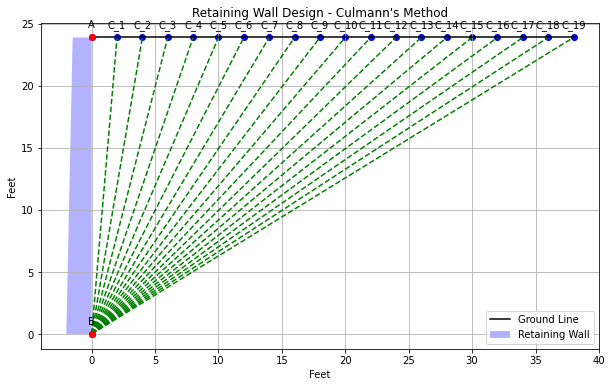

In [13]:
results.plot_results()

In [10]:
# from civilpy.general.jupyter import notebook_to_pdf

# Replace this with the correct path to your notebook, the pdf will be generated in the same folder
notebook_to_pdf(r"D:\Jetbrains\PycharmProjects\civilpy\Notebooks\Live_Load_Lateral_Surcharge_Best_Practice.ipynb")

PDF created: D:\Jetbrains\PycharmProjects\civilpy\Notebooks\Live_Load_Lateral_Surcharge_Best_Practice.pdf
